In [1]:
# Visualization
import plotly.express as px # for data visualization

# Sklearn
from sklearn.datasets import load_digits # for MNIST data
from sklearn.datasets import make_swiss_roll # for swiss roll
from sklearn.manifold import Isomap # for Isomap dimensionality reduction
from sklearn.manifold import MDS # for MDS dimensionality reduction
from sklearn.preprocessing import StandardScaler # for data standardization
from sklearn.decomposition import PCA # for PCA analysis

from tqdm import tqdm
import torch
from torch_tda.nn import RipsLayer, Rips0Layer
from herabottleneck import BottleneckLayerHera

from PH_projection_pursuit import bottleneck_proj_pursuit, subsample_bats, cayley_update
import glob
import numpy as np
import matplotlib.pyplot as plt
import bats
from sklearn.metrics.pairwise import pairwise_distances
from dr_visualization import plot_H1, PD_uncertainty, plotly_2D_scatter

In [2]:
def PH_compute(X, ps_length_thres):
    DX = pairwise_distances(X)
    rX = bats.enclosing_radius(bats.Matrix(DX))
    # maixmum complex dimension = maximum homology dimension + 1
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX , 2)
    flags = (bats.extra_reduction_flag(), bats.clearing_flag())
    R = bats.reduce(F, bats.F2(), *flags)
    ps = []
    for i in range(2):
        ps.extend(R.persistence_pairs(i))

    fig, ax = bats.persistence_diagram(ps)

    for p in ps:
        if p.death() != np.inf and p.death() - p.birth() > ps_length_thres and p.dim()==1:
            print(p)

Below, we will use the COIL-100 data set downloaded from https://www.kaggle.com/jessicali9530/coil100. But you can try with any other data sets (if your number of data points exceeds 100, then either keep patient and wait or try to sample points as in https://bats-tda.readthedocs.io/en/latest/examples/rips.html#greedy-subsampling).

1 : (9.69925,18.717) <99,6286>


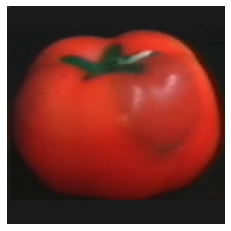

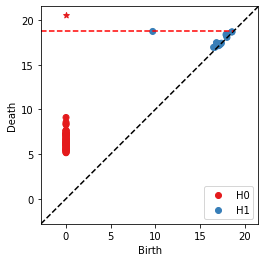

In [3]:
# index 10 is a cup
pic_ind = 4
array = plt.imread(f'data/coil-100/obj{pic_ind}__0.png')
plt.imshow(array)
plt.axis('off')
# plt.savefig('images/Coil-100/tomato.pdf')  

X = []
for file_name in glob.glob(f'data/coil-100/obj{pic_ind}__*.png'):
    array = plt.imread(file_name)
    X.append(array.reshape(-1,))
    
X = np.array(X, order = 'c', dtype=np.double)
PH_compute(X, 5)

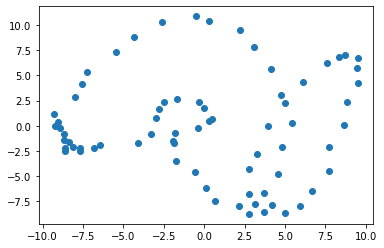

In [4]:
# try PCA first (we also find the first 10 eigenvectors)
X_pca10 = PCA(n_components=10).fit_transform(X)
plt.scatter(X_pca10[:, 0],X_pca10[:,1])

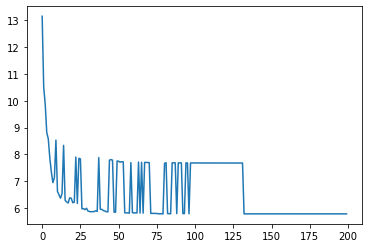

In [25]:
import torch
torch.manual_seed(4)
P, opt_info = bottleneck_proj_pursuit(X_pca10, scheduler_iter=20, opt_dim=10,
                                      optimizer_iter = 10)
plt.plot(opt_info['losses'])

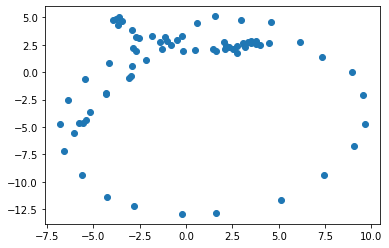

In [27]:
X_PH = X_pca10 @ P.T
plt.scatter(X_PH[:, 0],X_PH[:,1])

1 : (3.697,13.3572) <670,38312>


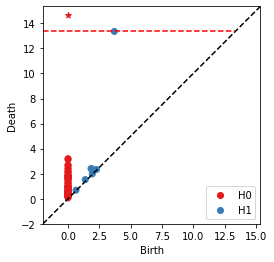

In [28]:
# print('bottleneck distance is ', opt_info['losses'][-1])
PH_compute(X_PH, 5) 

In [29]:
def compute_bot_dist_b0_b1(X,Y):
    layer = RipsLayer(maxdim=1, sparse = True, 
                  reduction_flags=(bats.standard_reduction_flag(), 
                                             bats.clearing_flag(),))
    crit = BottleneckLayerHera()
    Xt = torch.tensor(X, dtype=torch.double)
    Yt = torch.tensor(Y, dtype=torch.double)
    X_dgm = layer(Xt)
    Y_dgm = layer(Yt)
    bd0 = crit(Y_dgm[0], X_dgm[0])
    bd1 = crit(Y_dgm[1], X_dgm[1])
    bd = max(bd0.detach().numpy(), bd1.detach().numpy())
    return bd0, bd1

bd0, bd1 = compute_bot_dist_b0_b1(X, X_PH)
bd1.item()

3.7026423870462484

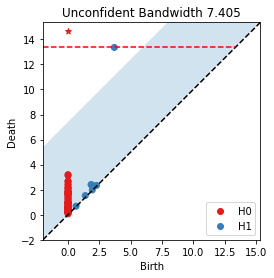

In [30]:
def PH_uncert_plot(X, uncertainty_length, save_path = None):
    DX = pairwise_distances(X)
    rX = bats.enclosing_radius(bats.Matrix(DX))
    F = bats.LightRipsFiltration(bats.Matrix(DX), rX , 2)
    flags = (bats.extra_reduction_flag(), bats.clearing_flag())
    R = bats.reduce(F, bats.F2(), *flags)
    ps = []
    for i in range(2):
        ps.extend(R.persistence_pairs(i))
        
    fig, ax = PD_uncertainty(ps, uncertainty_length)
    ax.set_title(f"Unconfident Bandwidth {uncertainty_length:.3f}")
    if save_path:
        fig.savefig(save_path, format="pdf", bbox_inches='tight')
        
X_dr = X_PH 
bt_dist = bd1.item()
PH_uncert_plot(X_dr, bt_dist*2)

Since bottleneck distance is not convex, if you run it again, you might see different reduction results(end up in a local minimum).

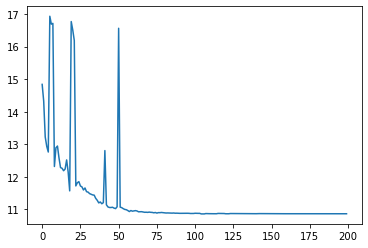

In [33]:
P, opt_info = bottleneck_proj_pursuit(X_pca10, scheduler_iter=20, opt_dim=10,
                                      optimizer_iter = 10)
plt.plot(opt_info['losses'])

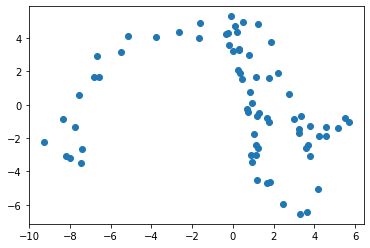

In [38]:
X_PH = X_pca10 @ P.T
plt.scatter(X_PH[:, 0],X_PH[:,1])

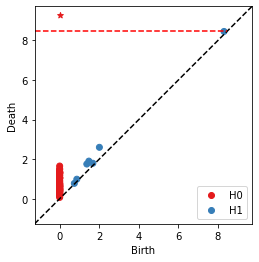

In [39]:
PH_compute(X_PH, opt_info['losses'][-1]) 

In [40]:
bd0, bd1 = compute_bot_dist_b0_b1(X, X_PH)
bd1.item()

16.810525414192405

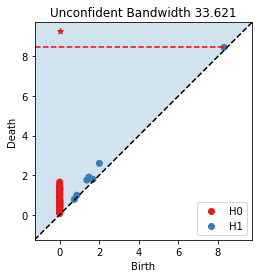

In [41]:
X_dr = X_PH 
bt_dist = bd1.item()
PH_uncert_plot(X_dr, bt_dist*2)